In [1]:
import cv2
import os
import random
import numpy as np
import matplotlib.pyplot as plt

from gaussian_splatting.colmap import parse_cameras, parse_images, parse_points3d, clean_text
from gaussian_splatting.model import View, GaussianCloud, train
from gaussian_splatting.model.util import create_rasterizer

random.seed(42)

In [2]:
dataset = "cat"

In [3]:
# parsing colmap output
images = {
    image_name: cv2.imread(f"../data/{dataset}/images/{image_name}")[:, :, ::-1] / 255
    for image_name in os.listdir(f"../data/{dataset}/images/")
}
with open(f"../data/{dataset}/cameras.txt", "r")  as f:
    cameras = parse_cameras(clean_text(f.readlines()))

with open(f"../data/{dataset}/points3D.txt", "r")  as f:
    points3d = parse_points3d(clean_text(f.readlines()))

with open(f"../data/{dataset}/images.txt", "r")  as f:
    images = parse_images(clean_text(f.readlines()), cameras, points3d, images)
    

In [4]:
# creating views
views = [View.from_image(image) for image in images.values()]
views[:4]

[View at (4.453357536663497, -0.10547240994974243, 1.9247751954678085),
 View at (4.383400398237235, -0.0897887832366131, 1.7901774746821242),
 View at (4.476125139247135, -0.10867348453713621, 2.0188284792252764),
 View at (4.477249819588436, -0.08991988498171113, 2.068228432834314)]

In [5]:
# train/test splitting of views
random.shuffle(views)
train_split = 0.7
dataset_size = len(views)
train_dataset = views[:int(dataset_size*train_split)]
test_dataset = views[int(dataset_size*train_split):]

In [6]:
gaussian_cloud = GaussianCloud.from_point_cloud([*points3d.values()]).to("cuda")
gaussian_cloud

Gaussian Cloud of 5371 points in cuda:0

In [7]:
def compare(view: View, gaussian_cloud: GaussianCloud):
    gaussian_cloud.eval()
    model = create_rasterizer(view)
    _img, _ = model(**gaussian_cloud.parameters)
    npimg = _img.cpu().detach().numpy().transpose([1, 2, 0])
    orig_img = view.image
    plt.imshow(np.hstack([npimg, orig_img]))
    plt.show()

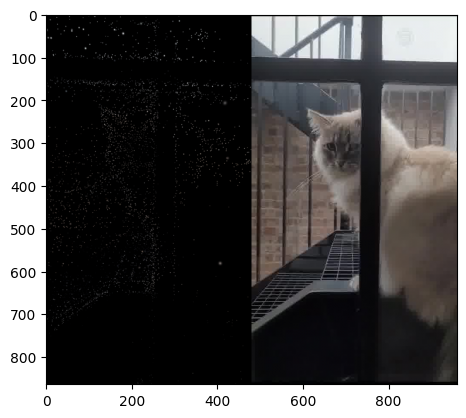

In [8]:
compare(test_dataset[1], gaussian_cloud)

In [9]:
gaussian_cloud.train()
train_losses, test_losses = train(gaussian_cloud, train_dataset, test_dataset)

  10:  loss=0.392182
  20:  loss=0.278579
  30:  loss=0.211026
  40:  loss=0.177821
  50:  loss=0.154810
  60:  loss=0.138057
  70:  loss=0.125407
  80:  loss=0.114974
  90:  loss=0.106028
 100:  loss=0.098181
 110:  loss=0.104960
 120:  loss=0.095033
 130:  loss=0.089679
 140:  loss=0.085395
 150:  loss=0.083282
 160:  loss=0.081207
 170:  loss=0.079124
 180:  loss=0.077967
 190:  loss=0.076403
 200:  loss=0.075340
 210:  loss=0.083648
 220:  loss=0.078825
 230:  loss=0.076693
 240:  loss=0.074723
 250:  loss=0.073510


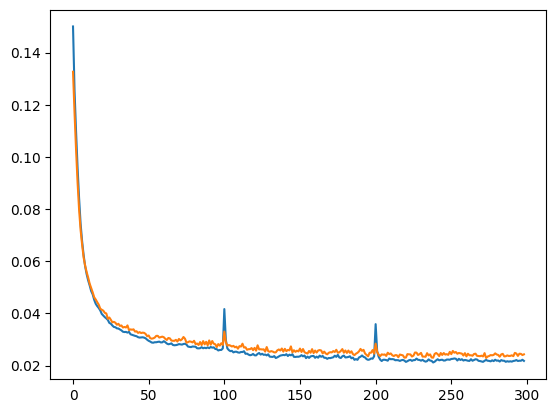

In [ ]:
plt.plot(train_losses)
plt.plot(test_losses)

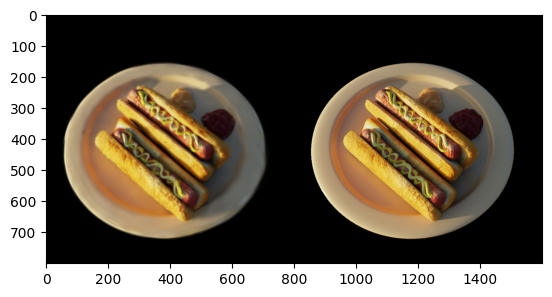

In [ ]:
compare(test_dataset[1], gaussian_cloud)

In [ ]:
gaussian_cloud.save(f"../models/{dataset}.pkl")